In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))
    
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:6] 
n_proc = 8
rank = 0


In [6]:
%%px

from DataDownload import DataDownload

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = False
store_on_file = True
auth_token = "com.gmail.jhelsas-b854269a"

folder = "/home/admin/scratch"
filename = "aws-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    
    ddwnld = DataDownload()
    vx,vy,vz = ddwnld.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,rank,auth_token)
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    comm.Barrier(); t1=MPI.Wtime()
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

CompositeError: one or more exceptions from call to method: execute
[Engine Exception]EngineError: Engine 0 died while running task u'491628d1-b1a5dd2ec4925849db6479a6'
[Engine Exception]EngineError: Engine 1 died while running task u'32b1db24-8fd7ca8a0cb174444cefc50b'
[Engine Exception]EngineError: Engine 2 died while running task u'337f437c-04620fd00c60a3187a3072b4'
[Engine Exception]EngineError: Engine 3 died while running task u'1647dfae-35cfaae8059160de3b708d0d'
.... 4 more exceptions ...

In [6]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
k2,kx,ky,kz=myEnergySpc.GetWavenumbers(nx,ny,nz,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate all wavenumbers: 36.39 seconds


In [7]:
%%px 
comm.Barrier(); t1=MPI.Wtime()

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

cvx = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvy = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvz = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial FFT: 52.01 seconds


In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvx[:,:,:] = fft.forward3Dfft(vx,nx,ny,nz,nproc,rank)
cvy[:,:,:] = fft.forward3Dfft(vy,nx,ny,nz,nproc,rank)
cvz[:,:,:] = fft.forward3Dfft(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial FFT: 92.55 seconds


In [9]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cSxx=np.complex64(0.0+1.0j)*kx*cvx
cSyy=np.complex64(0.0+1.0j)*ky*cvy
cSzz=np.complex64(0.0+1.0j)*kz*cvz

cSxy=np.complex64(0.0+0.5j)*(kx*cvy+ky*cvx)
cSxz=np.complex64(0.0+0.5j)*(kx*cvz+kz*cvx)
cSyz=np.complex64(0.0+0.5j)*(ky*cvz+kz*cvy)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate strainrate in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate vorticity in k space: 126.53 seconds


In [10]:
%%px
comm.Barrier(); t1=MPI.Wtime()

Sxx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
Syy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
Szz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

Sxy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
Sxz = ft.zeros_aligned((nx,ny,nz), dtype='float32')
Syz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocate real space arrays: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Alocate real space arrays: 20.60 seconds


In [11]:
%%px 
comm.Barrier(); t1=MPI.Wtime()

cSxx[kz==(Nz//2)] = 0.
cSyy[kz==(Nz//2)] = 0.
cSzz[kz==(Nz//2)] = 0.

cSxy[kz==(Nz//2)] = 0.
cSxz[kz==(Nz//2)] = 0.
cSyz[kz==(Nz//2)] = 0.

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Zeroing odd-ball wavenumber: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Zeroing odd-ball wavenumber: 28.64 seconds


In [12]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:

Sxx[:,:,:]=fft.backward3Dfft(cSxx,nx,ny,nz,nproc,rank)
Syy[:,:,:]=fft.backward3Dfft(cSyy,nx,ny,nz,nproc,rank)
Szz[:,:,:]=fft.backward3Dfft(cSzz,nx,ny,nz,nproc,rank)

Sxy[:,:,:]=fft.backward3Dfft(cSxy,nx,ny,nz,nproc,rank)
Syz[:,:,:]=fft.backward3Dfft(cSyz,nx,ny,nz,nproc,rank)
Sxz[:,:,:]=fft.backward3Dfft(cSxz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial inverse FFT: 179.89 seconds


In [13]:
%%px
#Fixing: forgot the factor of 2 on the second half
S2 = Sxx**2+Syy**2+Szz**2 + 2.0*(Sxy**2+Syz**2+Sxz**2)

In [14]:
%%px

cacheStrainrateData = True
loadStrainrateFromCache = False

folder = "/home/idies/workspace/scratch"
filename = "ref-strainrate-"+str(rank)+".npz"
file = folder + "/" + filename

if(loadStrainrateFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    S2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    S2[:,:,:] = content['S2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheStrainrateData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,S2=S2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] Caching the data: 33.06 seconds


In [14]:
%%px
comm.Barrier(); t1=MPI.Wtime()

avgEpsilon = np.average(S2)
avgEpsilonGl=np.zeros(1,dtype='float32')

comm.Reduce([avgEpsilon,MPI.REAL],[avgEpsilonGl,MPI.REAL],op=MPI.SUM)
avgEpsilon = avgEpsilonGl[0]/nproc
avgEpsilon = comm.bcast(avgEpsilon, root=0)

##########################

minS2 = S2.min()
maxS2 = S2.max()

minS2Gl=np.zeros(nproc,dtype='float32')
maxS2Gl=np.zeros(nproc,dtype='float32')

comm.Allgather([minS2,MPI.REAL],[minS2Gl,MPI.REAL])
comm.Allgather([maxS2,MPI.REAL],[maxS2Gl,MPI.REAL])

minS2 = minS2Gl.min()
maxS2 = maxS2Gl.max()

comm.Barrier()

if rank==0:
    print("<S^2> : "+str(avgEpsilon))
    print("min S2/<S^2> : "+str(minS2/avgEpsilon))
    print("min S2/<S^2> : "+str(maxS2/avgEpsilon))

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate average strainrate: {0:.2f} seconds\n'.format(t2-t1))


[stdout:2] 
<S^2> : 249.217727661
min S2/<S^2> : 3.98580435798e-05
min S2/<S^2> : 225.01032742
Calculate average strainrate: 1.14 seconds


nu = 0.000185

urms = 0.674645176394, Reference: 0.6820399

eps = 0.0922105592346

kinectic energy = 0.682719171047

Taylor micro-scale =0.117035222558

ReLamb = 426.795937119, Reference: 426.8378

In [16]:
%%px

nu = isotropic1024coarse['nu']
if rank==0:
    print("Dissipation rate = "+str(2*nu*avgEpsilon))

[stdout:2] Dissipation rate = 0.0922105592346


In [17]:
%%px
S2_bins = np.load('dissipation_bins.npy')
S2_pdf = np.load('dissipation_pdf.npy')

Nbins = S2_bins.shape[0]
s2temp = S2[S2<=20*avgEpsilon] 
s2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(s2temp/avgEpsilon,S2_bins)

In [18]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[s2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:2]

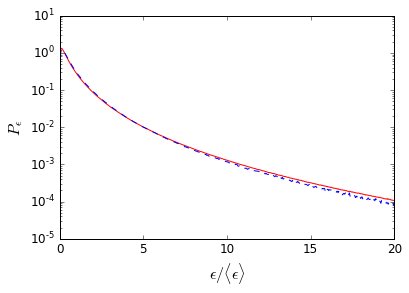

In [19]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((20*avgEpsilon-minS2)/(avgEpsilon*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

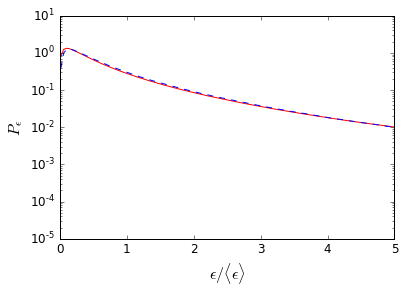

In [20]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((20*avgEpsilon-minS2)/(avgEpsilon*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

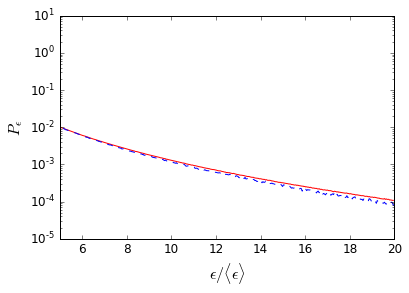

In [22]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    plt.xlim(5,20)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((20*avgEpsilon-minS2)/(avgEpsilon*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

In [32]:
%%px

Nbins = 1024*32
stemp = S2[:,:,:] 
s2red=np.zeros(Nbins,dtype='int')
lbins = np.logspace(np.log10(minS2/avgEpsilon),np.log10(maxS2/avgEpsilon),Nbins)
histred,edgesred = np.histogram(stemp/avgEpsilon,lbins)

In [33]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[s2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()
    
left = edgesred[0:(Nbins-1)]
right = edgesred[1:Nbins]
normhist = (histred*(1024**(-3)))/(right-left)

if rank==0:
    norm = np.sum(normhist*(right-left))

[output:2]

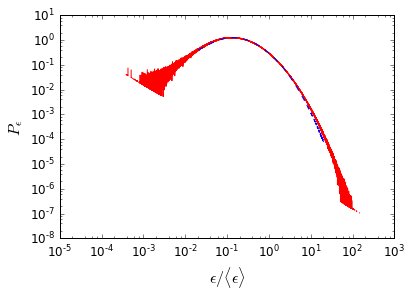

In [34]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.loglog((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.loglog(S2_bins,S2_pdf,'b--')

[output:2]

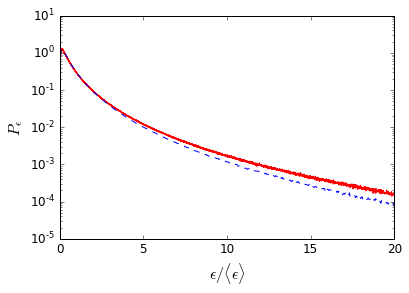

In [35]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    plt.xlim(0,20)
    plt.ylim(10**(-5),10**(1))

    plt.semilogy((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

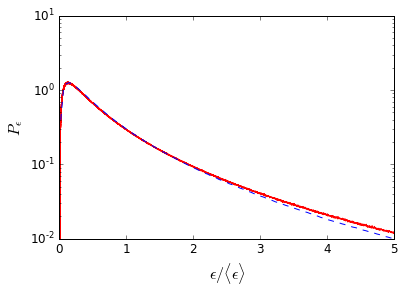

In [36]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    plt.xlim(0,5)
    plt.ylim(10**(-2),10**(1))

    plt.semilogy((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

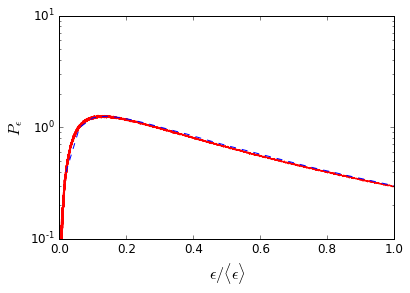

In [37]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    plt.xlim(0,1)
    plt.ylim(10**(-1),10**(1))

    plt.semilogy((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

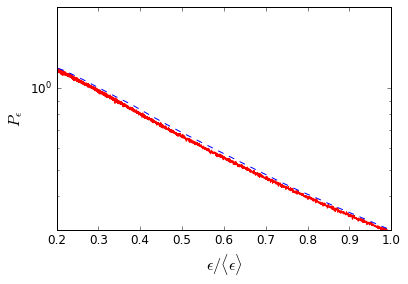

In [38]:
%%px

%matplotlib inline
s2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    plt.xlim(0.2,1)
    plt.ylim(0.3,2)

    plt.semilogy((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

In [39]:
%%px

#Nbins = 1024*32
#stemp = S2[:,:,:] 
#s2red=np.zeros(Nbins,dtype='int')
#lbins = np.logspace(np.log10(minS2/avgEpsilon),np.log10(maxS2/avgEpsilon),Nbins)
#histred,edgesred = np.histogram(stemp/avgEpsilon,lbins)

Nbins = 4*1024
stemp = S2[:,:,:] 
s2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(stemp/avgEpsilon,np.linspace(minS2/avgEpsilon, maxS2/avgEpsilon, Nbins))
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [40]:
%%px

blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[s2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:2]

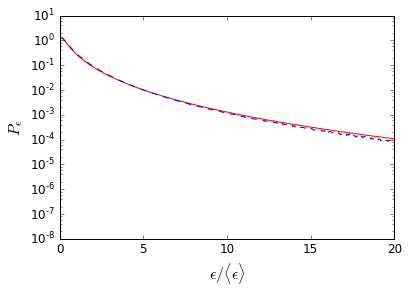

In [45]:
%%px
%matplotlib inline
#w2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    plt.xlim(0,20)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((maxS2-minS2)/(avgEpsilon*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

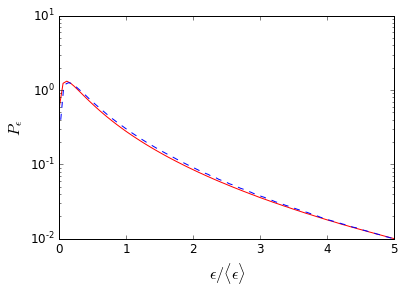

In [47]:
%%px
%matplotlib inline
#w2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    plt.xlim(0,5)
    plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((maxS2-minS2)/(avgEpsilon*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')

[output:2]

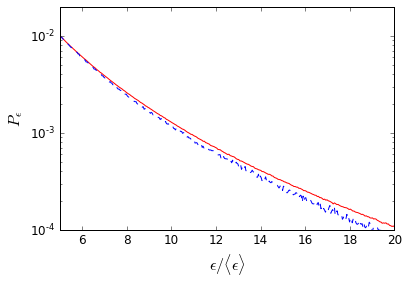

In [49]:
%%px
%matplotlib inline
#w2red[-1] = 0
if rank==0:
    S2_bins = np.load('dissipation_bins.npy')
    S2_pdf = np.load('dissipation_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\epsilon/{\langle \epsilon\rangle}$')
    plt.ylabel(r'$P_{\epsilon}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    plt.xlim(5,20)
    plt.ylim(10**(-4),2*10**(-2))

    plt.semilogy(edgesred,(s2red*(1024**(-3)))/((maxS2-minS2)/(avgEpsilon*Nbins)),'r',label='Unfiltered')
    plt.semilogy(S2_bins,S2_pdf,'b--')